In [1]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/audio/
  inflating: dataset/audio/aileenhernandez_5_2.wav  
  inflating: dataset/audio/antonyflew_10.wav  
  inflating: dataset/audio/daningram_15.wav  
  inflating: dataset/audio/georgeklein_5_2.wav  
  inflating: dataset/audio/JackHanna_10.wav  
  inflating: dataset/audio/JimmyFratianno_0.wav  
  inflating: dataset/audio/paulhornung_10.wav  
  inflating: dataset/audio/RobinWilliams_0.wav  
  inflating: dataset/audio/SteveLawrence_15.wav  
  inflating: dataset/audio/terryjones_5.wav  
   creating: dataset/transcripts/


In [2]:
!nvidia-smi

Tue Apr 15 16:20:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.5     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off | 00000000:47:00.0 Off |                   On |
| N/A   24C    P0              57W / 400W |                  N/A |     N/A      Default |
|                                         |                      |            Disabled* |
+-----------------------------------------+----------------------+--

In [5]:
!pip uninstall flash-attn --yes

Found existing installation: flash-attn 2.4.2
Uninstalling flash-attn-2.4.2:
  Successfully uninstalled flash-attn-2.4.2


In [6]:
pip install transformers==4.35.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 13.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 7.9 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 1.2 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.30.2
    Uninstalling huggingface-hub-0.30.2:
      Successfully uninstalled huggingface-hub-0.30.2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3

[notice] A new release of pip is availabl

In [7]:
pip install --upgrade 'optree>=0.13.0'

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 8.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: optree
    Found existing installation: optree 0.11.0
    Uninstalling optree-0.11.0:
      Successfully uninstalled optree-0.11.0

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install transformers torchaudio librosa soundfile nltk gensim scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 5.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
#STEP_1_Preprocessing audio and converting to text.
import os
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import warnings

warnings.filterwarnings("ignore")

AUDIO_DIR = "dataset/audio"
TRANSCRIPT_DIR = "dataset/transcripts"
os.makedirs(TRANSCRIPT_DIR, exist_ok=True)

print("Loading model")
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

def transcribe_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    input_values = tokenizer(waveform.squeeze().numpy(), return_tensors="pt").input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = tokenizer.decode(predicted_ids[0])
    return transcription.lower()

print("Transcribing audio files")
for filename in sorted(os.listdir(AUDIO_DIR)):
    if filename.endswith(".wav"):
        audio_path = os.path.join(AUDIO_DIR, filename)
        transcript = transcribe_audio(audio_path)
        
        base_name = os.path.splitext(filename)[0]
        with open(os.path.join(TRANSCRIPT_DIR, base_name + ".txt"), "w") as f:
            f.write(transcript)

        print(f"[*] {filename} → {transcript}")

Loading model


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2

Transcribing audio files
[*] JackHanna_10.wav → seconds the hanna family the clumbazes since nezo the new world this is obviousy a tible tragedy but however we have given over tens of millions of dollars of the last years to the girl of world both lowd and in mountain girlis i ave to happen t have home three miles where th girlis lives in roanda does the mountai girlis however what you see here you hear the screaming going on her him heare i know hehear the screaming gong our watchat girlas response by the way he doesn't know what's going on an tis a silver back bolly not a female he hears ere spotchig see from the face n the mouth he's alarmed yes he goes over looks at the little child there to no doubt about that what happens when you tranquilize the animal whether's to garilla whatever animal might be and was out do researches in the wild with girillas ive seen what happens so know what happens in that dark hits the animal this animal you coul imagine the animals tit's not us like a

In [ ]:
#STEP_2_Extracting relevant features.
import re
import librosa
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

AUDIO_DIR = "dataset/audio"
TRANSCRIPT_DIR = "dataset/transcripts"

def count_hesitations(text):
    return len(re.findall(r'\b(uh|um|erm|eh|hmm|ah)\b', text.lower()))

def count_pauses(text):
    return count_hesitations(text)

def calc_speech_rate(text, duration_sec):
    word_count = len(text.split())
    return word_count / duration_sec if duration_sec > 0 else 0

def calc_pitch_variability(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    pitches, _ = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[pitches > 0]
    return np.std(pitch_values) if len(pitch_values) > 0 else 0

def count_vague_words(text):
    vague_words = ['thing', 'stuff', 'something', 'somewhere']
    return sum(text.lower().split().count(w) for w in vague_words)

def is_incomplete_sentence(text):
    endings = ["and", "but", "then", ","]
    words = text.lower().split()
    if len(words) < 4 or text.strip().endswith(tuple(endings)):
        return 1
    return 0

def count_lost_words(text):
    return len(re.findall(r'\b(that thing|you know|like)\b', text.lower()))

def build_sgns_model(texts):
    tokenized = [text.lower().split() for text in texts]
    return Word2Vec(sentences=tokenized, vector_size=100, window=5, sg=1, negative=5, min_count=1, workers=2)

def compute_semantic_anomaly(sent, model):
    words = sent.lower().split()
    vectors = [model.wv[w] for w in words if w in model.wv]
    if len(vectors) < 2:
        return 0
    mean_vec = np.mean(vectors, axis=0).reshape(1, -1)
    sim = cosine_similarity(vectors, mean_vec)
    return 1 - np.mean(sim)

def load_all_texts_and_audio():
    data = []
    for filename in sorted(os.listdir(TRANSCRIPT_DIR)):
        if filename.endswith(".txt"):
            file_id = filename.replace(".txt", "")
            with open(os.path.join(TRANSCRIPT_DIR, filename)) as f:
                text = f.read().strip()

            audio_path = os.path.join(AUDIO_DIR, file_id + ".wav")
            duration = librosa.get_duration(path=audio_path)
            data.append((file_id, text, audio_path, duration))
    return data

print("Extracting Features")

raw_data = load_all_texts_and_audio()
texts_only = [t for _, t, _, _ in raw_data]
sgns_model = build_sgns_model(texts_only)

results = []

for file_id, text, audio_path, duration in raw_data:
    features = {
        "file": file_id,
        "hesitation_count": count_hesitations(text),
        "pause_count": count_pauses(text),
        "speech_rate": calc_speech_rate(text, duration),
        "pitch_variability": calc_pitch_variability(audio_path),
        "semantic_anomaly": compute_semantic_anomaly(text, sgns_model),
        "vague_word_count": count_vague_words(text),
        "incomplete_sentence": is_incomplete_sentence(text),
        "lost_words": count_lost_words(text)
    }
    results.append(features)

df = pd.DataFrame(results)
df.to_csv("features.csv", index=False)

print("Saved to features.csv")
print(df)

Extracting Features
Saved to features.csv
                  file  hesitation_count  pause_count  speech_rate  \
0         JackHanna_10                 0            0     4.032559   
1     JimmyFratianno_0                 0            0     2.249602   
2      RobinWilliams_0                 0            0     3.057901   
3     SteveLawrence_15                 0            0     3.245069   
4  aileenhernandez_5_2                 0            0     3.177778   
5        antonyflew_10                 0            0     2.022222   
6         daningram_15                 0            0     3.086957   
7      georgeklein_5_2                 0            0     4.142857   
8       paulhornung_10                 0            0     3.000000   
9         terryjones_5                 1            1     3.045455   

   pitch_variability  semantic_anomaly  vague_word_count  incomplete_sentence  \
0         951.278076          0.192075                 0                    0   
1        1031.186646     

                  file isof_risk_label kmeans_risk_label
0         JackHanna_10          Normal            Normal
1     JimmyFratianno_0          Normal            Normal
2      RobinWilliams_0         At Risk            Normal
3     SteveLawrence_15          Normal            Normal
4  aileenhernandez_5_2          Normal            Normal
5        antonyflew_10          Normal            Normal
6         daningram_15          Normal            Normal
7      georgeklein_5_2          Normal            Normal
8       paulhornung_10          Normal            Normal
9         terryjones_5         At Risk           At Risk


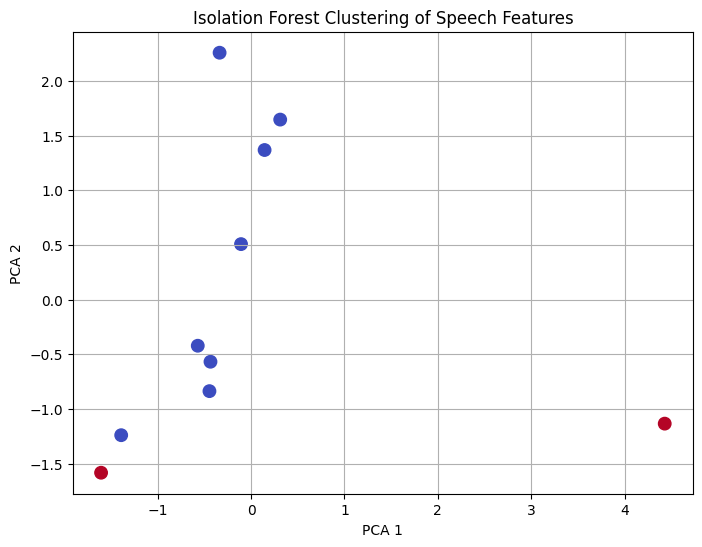

In [12]:
#STEP_3_Basic Unsupervised ML approach.
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv("features.csv")

feature_cols = [
    "hesitation_count", "pause_count", "speech_rate", "pitch_variability", 
    "semantic_anomaly", "vague_word_count", "incomplete_sentence", "lost_words"
]

X = df[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

isof = IsolationForest(contamination=0.2, random_state=42)
df['isof_risk'] = isof.fit_predict(X_scaled)
df['isof_risk_label'] = df['isof_risk'].apply(lambda x: 'At Risk' if x == -1 else 'Normal')

kmeans = KMeans(n_clusters=2, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

cluster_means = df.groupby("kmeans_cluster")[feature_cols].mean()
risk_cluster = cluster_means["hesitation_count"].idxmax()
df['kmeans_risk_label'] = df['kmeans_cluster'].apply(lambda x: 'At Risk' if x == risk_cluster else 'Normal')

df.to_csv("clustered_results.csv", index=False)
print(df[["file", "isof_risk_label", "kmeans_risk_label"]])

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=(df['isof_risk_label'] == "At Risk"), cmap="coolwarm", s=80)
plt.title("Isolation Forest Clustering of Speech Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.savefig("clustering_plot.png")
plt.show()